In [1]:
import pandas as pd
import numpy as np
import time
import re
import string
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import nltk as nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt

In [2]:
# Viewing settings
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [3]:
# Filters
DC_filter = ['cummings']
MC_filter = ['matthancock', 'matt hancock']

In [4]:
def filter_data(data, filters = DC_filter):
    #Function to filter the weekly data to UK tweets only
    
    #First filter by language to english only
    data = data.loc[data['lang'].str.contains('en', na=False)]
    print("there are ", len(data), "english tweets")
    
    #Next filter by dominic cummings/matt hancock related tweets using the keywords list
    data = data.loc[data['text'].str.contains('|'.join(filters), na=False)]
    
    #Reset index
    data.reset_index(drop=True, inplace=True)
    
    return data

# Now performing the actual filtering, language filtered by english and user.location based on a list of cities/country names defined from UK Cities List

## Loading the data

In [5]:
this_data = pd.read_pickle('/Users/brandon/Documents/UCL/Project/COVID Project/Data/DC_Data_Week_2')
this_data.head(5)

,created_at,text,user.location,lang
0,2020-06-04 16:40:08+00:00,RT @vaanessaaa4: Why were you going to meet up with a 15 year old at 2 am?,"Boston, MA",en
1,2020-06-04 16:40:08+00:00,RT @_danielaabade: A mulher que matou Miguel no Recife é a esposa de Sergio Hacker: Sari Gaspar Corte Real. Família Hacker coleciona prefei…,Demi Lovato é meu amor,pt
2,2020-06-04 16:40:08+00:00,"RT @SureshNakhua: #Indian &amp; #Nepali health professionals are collaborating their efforts on ground.\n\nIndia is committed to prepare, act &amp; s…",NaN,en
3,2020-06-04 16:40:08+00:00,"RT @pissedsam: HI ITS ILLEGAL TO OPENLY CARRY A FIREARM, LOADED OR UNLOADED, IN PUBLIC IN CALIFORNIA. CALIFORNIA PENAL CODE 26350. CANT IMA…","Florida, USA",en
4,2020-06-04 16:40:08+00:00,@Iamablur @OmarMKE1 @MayorOfMKE @matcmilwaukee PS MATC alumni are literally the ones keeping #MKE working during th… https://t.co/vfhRhfcrjY,"Milwaukee, WI",en


In [6]:
print(len(this_data))

19518132


## Filtering the data

In [7]:
this_data = filter_data(this_data)
this_data.head(5)

there are  11683848 english tweets


,created_at,text,user.location,lang
0,2020-06-04 16:42:00+00:00,@calumbrawley8 @davidcummings00 So gathering in thousands in a global pandemic after 10+ weeks of lockdown is ok?,NaN,en
1,2020-06-04 16:45:11+00:00,"@sammwhiting I gave up after cummings, its not good for ur mental health","North West, England",en
2,2020-06-04 16:49:55+00:00,@BBCNews Unless its dominic cummings house that is.,NaN,en
3,2020-06-04 16:52:54+00:00,Why isn't mandatory to wear #facemasks in #publicplaces yet @MattHancock @BorisJohnson @dominiccummings? #covid19,"Liverpool, England",en
4,2020-06-04 17:00:13+00:00,"@Nigel_Farage Both should resign, altho the labour guy did apologise. Wonder if its true that cummings sister was i… https://t.co/HWM1u4rwbd","Scotland, United Kingdom",en


In [8]:
print(len(this_data))

627


## Clean Tweets for Sentiment Analysis

In [9]:
def remove_pattern(input_txt, pattern):
    """Function to help remove tweet specific patterns"""
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)        
    return input_txt

In [10]:
def clean_tweets(tweets):
    """Function to clean tweets specifically as they contain certain patterns and formats different to a normal sentence"""
    #remove twitter Return handles (RT @xxx:)
    tweets = np.vectorize(remove_pattern)(tweets, "RT @[\w]*:") 
    
    #remove twitter handles (@xxx)
    tweets = np.vectorize(remove_pattern)(tweets, "@[\w]*")
    
    #remove URL links (httpxxx)
    tweets = np.vectorize(remove_pattern)(tweets, "https?://[A-Za-z0-9./]*")
    
    #remove special characters, numbers, punctuations (except for #)
    tweets = np.core.defchararray.replace(tweets, "[^a-zA-Z]", " ")
    
    return tweets

In [11]:
#Cleaning the tweets
this_data['clean_tweet'] = clean_tweets(this_data['text'])
this_data.head(10)

,created_at,text,user.location,lang,clean_tweet
0,2020-06-04 16:42:00+00:00,@calumbrawley8 @davidcummings00 So gathering in thousands in a global pandemic after 10+ weeks of lockdown is ok?,NaN,en,So gathering in thousands in a global pandemic after 10+ weeks of lockdown is ok?
1,2020-06-04 16:45:11+00:00,"@sammwhiting I gave up after cummings, its not good for ur mental health","North West, England",en,"I gave up after cummings, its not good for ur mental health"
2,2020-06-04 16:49:55+00:00,@BBCNews Unless its dominic cummings house that is.,NaN,en,Unless its dominic cummings house that is.
3,2020-06-04 16:52:54+00:00,Why isn't mandatory to wear #facemasks in #publicplaces yet @MattHancock @BorisJohnson @dominiccummings? #covid19,"Liverpool, England",en,Why isn't mandatory to wear #facemasks in #publicplaces yet ? #covid19
4,2020-06-04 17:00:13+00:00,"@Nigel_Farage Both should resign, altho the labour guy did apologise. Wonder if its true that cummings sister was i… https://t.co/HWM1u4rwbd","Scotland, United Kingdom",en,"Both should resign, altho the labour guy did apologise. Wonder if its true that cummings sister was i…"
5,2020-06-04 17:00:47+00:00,@piersmorgan Werent you going mental at cummings the other week for breaking lockdown rules? Surely him in a car is… https://t.co/JhiEb8MYti,"Scarborough, England",en,Werent you going mental at cummings the other week for breaking lockdown rules? Surely him in a car is…
6,2020-06-04 17:19:52+00:00,So let’s see if the #cummingsprecedent or #cummingsdefence comes in to play again when Mr.Johnson declares that the… https://t.co/AqWvGBALq9,NaN,en,So let’s see if the #cummingsprecedent or #cummingsdefence comes in to play again when Mr.Johnson declares that the…
7,2020-06-04 17:27:44+00:00,@johnccummings @JasonManford Because all viruses have a natural repetition ratio you get herd immunity once a certa… https://t.co/64MICmZOhU,bradford,en,Because all viruses have a natural repetition ratio you get herd immunity once a certa…
8,2020-06-04 17:33:22+00:00,"#dominiccummings Alok Sharma tests negative for Coronavirus. Can someone tell Cummings quick, before he drives off… https://t.co/waxGlFYqpd",NaN,en,"#dominiccummings Alok Sharma tests negative for Coronavirus. Can someone tell Cummings quick, before he drives off…"
9,2020-06-04 18:17:22+00:00,I wish he would. And take Scummings when he does,"Bristol, England",en,I wish he would. And take Scummings when he does


In [12]:
#Compute sentiments
analyser = SentimentIntensityAnalyzer()
scores = []

for i in range(this_data['clean_tweet'].shape[0]):
    print(i)
    compound = analyser.polarity_scores(this_data['clean_tweet'][i])["compound"]
    pos = analyser.polarity_scores(this_data['clean_tweet'][i])["pos"]
    neu = analyser.polarity_scores(this_data['clean_tweet'][i])["neu"]
    neg = analyser.polarity_scores(this_data['clean_tweet'][i])["neg"]
    
    if compound >= 0.05:
        senti = 'positive'
    elif compound <= -0.05:
        senti = 'negative'
    else:
        senti = 'neutral'
    
    scores.append({"Compound": compound,
                       "Positive": pos,
                       "Negative": neg,
                       "Neutral": neu,
                       "Sentiment": senti
                  })

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [13]:
#Add to dataframe
sentiments_score = pd.DataFrame.from_dict(scores)
this_data = this_data.join(sentiments_score)
this_data.head(10)

,created_at,text,user.location,lang,clean_tweet,Compound,Positive,Negative,Neutral,Sentiment
0,2020-06-04 16:42:00+00:00,@calumbrawley8 @davidcummings00 So gathering in thousands in a global pandemic after 10+ weeks of lockdown is ok?,NaN,en,So gathering in thousands in a global pandemic after 10+ weeks of lockdown is ok?,0.0000,0.000,0.000,1.000,neutral
1,2020-06-04 16:45:11+00:00,"@sammwhiting I gave up after cummings, its not good for ur mental health","North West, England",en,"I gave up after cummings, its not good for ur mental health",-0.3412,0.000,0.179,0.821,negative
2,2020-06-04 16:49:55+00:00,@BBCNews Unless its dominic cummings house that is.,NaN,en,Unless its dominic cummings house that is.,0.0000,0.000,0.000,1.000,neutral
3,2020-06-04 16:52:54+00:00,Why isn't mandatory to wear #facemasks in #publicplaces yet @MattHancock @BorisJohnson @dominiccummings? #covid19,"Liverpool, England",en,Why isn't mandatory to wear #facemasks in #publicplaces yet ? #covid19,-0.0572,0.000,0.109,0.891,negative
4,2020-06-04 17:00:13+00:00,"@Nigel_Farage Both should resign, altho the labour guy did apologise. Wonder if its true that cummings sister was i… https://t.co/HWM1u4rwbd","Scotland, United Kingdom",en,"Both should resign, altho the labour guy did apologise. Wonder if its true that cummings sister was i…",0.4588,0.237,0.105,0.658,positive
5,2020-06-04 17:00:47+00:00,@piersmorgan Werent you going mental at cummings the other week for breaking lockdown rules? Surely him in a car is… https://t.co/JhiEb8MYti,"Scarborough, England",en,Werent you going mental at cummings the other week for breaking lockdown rules? Surely him in a car is…,0.4404,0.139,0.000,0.861,positive
6,2020-06-04 17:19:52+00:00,So let’s see if the #cummingsprecedent or #cummingsdefence comes in to play again when Mr.Johnson declares that the… https://t.co/AqWvGBALq9,NaN,en,So let’s see if the #cummingsprecedent or #cummingsdefence comes in to play again when Mr.Johnson declares that the…,0.3400,0.124,0.000,0.876,positive
7,2020-06-04 17:27:44+00:00,@johnccummings @JasonManford Because all viruses have a natural repetition ratio you get herd immunity once a certa… https://t.co/64MICmZOhU,bradford,en,Because all viruses have a natural repetition ratio you get herd immunity once a certa…,0.3612,0.152,0.000,0.848,positive
8,2020-06-04 17:33:22+00:00,"#dominiccummings Alok Sharma tests negative for Coronavirus. Can someone tell Cummings quick, before he drives off… https://t.co/waxGlFYqpd",NaN,en,"#dominiccummings Alok Sharma tests negative for Coronavirus. Can someone tell Cummings quick, before he drives off…",-0.5719,0.000,0.198,0.802,negative
9,2020-06-04 18:17:22+00:00,I wish he would. And take Scummings when he does,"Bristol, England",en,I wish he would. And take Scummings when he does,0.4019,0.231,0.000,0.769,positive


## Pre-processing text for Topic Modelling

In [14]:
#Defining:
LEMMATIZER = WordNetLemmatizer()
STOPWORDS = stopwords.words('english')
special_char = ['’', '…'] #found from trial and error
DC_list = ['cummings', 'dominiccummings']

In [15]:
def remove_emoji(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

In [16]:
def tokenise(text):
    """ Process a single line of text. """
    
    # Remove emoji's (since it's not really processable anymore, only needed for sentiment part)
    text_new = remove_emoji(text)

    # Strip trailing characters if any (e.g. newline)
    text_new = text_new.strip()
    
    # Remove puncuation
    text_new = ''.join(char for char in text_new if char not in string.punctuation)
    
    # Remove special characters
    text_new = ''.join(ch for ch in text_new if ch not in special_char)

    # Lower case
    text_new = text_new.lower()
    
    # Tokenise by space
    tokens = text_new.split()
    
    # Remove stopwords
    tokens = [word for word in tokens if word not in STOPWORDS]
    
    # Remove search criteria (i.e. cummings)
    tokens = [word for word in tokens if word not in DC_list]

    # Lemmatise each word
    tokens = [LEMMATIZER.lemmatize(word) for word in tokens]
    

    return tokens

In [17]:
this_data['tokenised'] = this_data['clean_tweet'].apply(lambda x: tokenise(x))
this_data['clean_text'] = this_data['tokenised'].apply(lambda x: ' '.join(x))
this_data.head(10)

,created_at,text,user.location,lang,clean_tweet,Compound,Positive,Negative,Neutral,Sentiment,tokenised,clean_text
0,2020-06-04 16:42:00+00:00,@calumbrawley8 @davidcummings00 So gathering in thousands in a global pandemic after 10+ weeks of lockdown is ok?,NaN,en,So gathering in thousands in a global pandemic after 10+ weeks of lockdown is ok?,0.0000,0.000,0.000,1.000,neutral,"[gathering, thousand, global, pandemic, 10, week, lockdown, ok]",gathering thousand global pandemic 10 week lockdown ok
1,2020-06-04 16:45:11+00:00,"@sammwhiting I gave up after cummings, its not good for ur mental health","North West, England",en,"I gave up after cummings, its not good for ur mental health",-0.3412,0.000,0.179,0.821,negative,"[gave, good, ur, mental, health]",gave good ur mental health
2,2020-06-04 16:49:55+00:00,@BBCNews Unless its dominic cummings house that is.,NaN,en,Unless its dominic cummings house that is.,0.0000,0.000,0.000,1.000,neutral,"[unless, dominic, house]",unless dominic house
3,2020-06-04 16:52:54+00:00,Why isn't mandatory to wear #facemasks in #publicplaces yet @MattHancock @BorisJohnson @dominiccummings? #covid19,"Liverpool, England",en,Why isn't mandatory to wear #facemasks in #publicplaces yet ? #covid19,-0.0572,0.000,0.109,0.891,negative,"[isnt, mandatory, wear, facemasks, publicplaces, yet, covid19]",isnt mandatory wear facemasks publicplaces yet covid19
4,2020-06-04 17:00:13+00:00,"@Nigel_Farage Both should resign, altho the labour guy did apologise. Wonder if its true that cummings sister was i… https://t.co/HWM1u4rwbd","Scotland, United Kingdom",en,"Both should resign, altho the labour guy did apologise. Wonder if its true that cummings sister was i…",0.4588,0.237,0.105,0.658,positive,"[resign, altho, labour, guy, apologise, wonder, true, sister]",resign altho labour guy apologise wonder true sister
5,2020-06-04 17:00:47+00:00,@piersmorgan Werent you going mental at cummings the other week for breaking lockdown rules? Surely him in a car is… https://t.co/JhiEb8MYti,"Scarborough, England",en,Werent you going mental at cummings the other week for breaking lockdown rules? Surely him in a car is…,0.4404,0.139,0.000,0.861,positive,"[werent, going, mental, week, breaking, lockdown, rule, surely, car]",werent going mental week breaking lockdown rule surely car
6,2020-06-04 17:19:52+00:00,So let’s see if the #cummingsprecedent or #cummingsdefence comes in to play again when Mr.Johnson declares that the… https://t.co/AqWvGBALq9,NaN,en,So let’s see if the #cummingsprecedent or #cummingsdefence comes in to play again when Mr.Johnson declares that the…,0.3400,0.124,0.000,0.876,positive,"[let, see, cummingsprecedent, cummingsdefence, come, play, mrjohnson, declares]",let see cummingsprecedent cummingsdefence come play mrjohnson declares
7,2020-06-04 17:27:44+00:00,@johnccummings @JasonManford Because all viruses have a natural repetition ratio you get herd immunity once a certa… https://t.co/64MICmZOhU,bradford,en,Because all viruses have a natural repetition ratio you get herd immunity once a certa…,0.3612,0.152,0.000,0.848,positive,"[virus, natural, repetition, ratio, get, herd, immunity, certa]",virus natural repetition ratio get herd immunity certa
8,2020-06-04 17:33:22+00:00,"#dominiccummings Alok Sharma tests negative for Coronavirus. Can someone tell Cummings quick, before he drives off… https://t.co/waxGlFYqpd",NaN,en,"#dominiccummings Alok Sharma tests negative for Coronavirus. Can someone tell Cummings quick, before he drives off…",-0.5719,0.000,0.198,0.802,negative,"[alok, sharma, test, negative, coronavirus, someone, tell, quick, drive]",alok sharma test negative coronavirus someone tell quick drive
9,2020-06-04 18:17:22+00:00,I wish he would. And take Scummings when he does,"Bristol, England",en,I wish he would. And take Scummings when he does,0.4019,0.231,0.000,0.769,positive,"[wish, would, take, scummings]",wish would take scummings


## Splitting the data-sets by sentiment

In [18]:
this_data_pos = this_data.loc[this_data['Sentiment'] == 'positive']
this_data_neg = this_data.loc[this_data['Sentiment'] == 'negative']
this_data_neu = this_data.loc[this_data['Sentiment'] == 'neutral']

In [19]:
print(this_data_pos.shape[0])
print(this_data_neg.shape[0])
print(this_data_neu.shape[0])

165
296
166


In [20]:
this_data_pos.head(100)

,created_at,text,user.location,lang,clean_tweet,Compound,Positive,Negative,Neutral,Sentiment,tokenised,clean_text
4,2020-06-04 17:00:13+00:00,"@Nigel_Farage Both should resign, altho the labour guy did apologise. Wonder if its true that cummings sister was i… https://t.co/HWM1u4rwbd","Scotland, United Kingdom",en,"Both should resign, altho the labour guy did apologise. Wonder if its true that cummings sister was i…",0.4588,0.237,0.105,0.658,positive,"[resign, altho, labour, guy, apologise, wonder, true, sister]",resign altho labour guy apologise wonder true sister
5,2020-06-04 17:00:47+00:00,@piersmorgan Werent you going mental at cummings the other week for breaking lockdown rules? Surely him in a car is… https://t.co/JhiEb8MYti,"Scarborough, England",en,Werent you going mental at cummings the other week for breaking lockdown rules? Surely him in a car is…,0.4404,0.139,0.000,0.861,positive,"[werent, going, mental, week, breaking, lockdown, rule, surely, car]",werent going mental week breaking lockdown rule surely car
6,2020-06-04 17:19:52+00:00,So let’s see if the #cummingsprecedent or #cummingsdefence comes in to play again when Mr.Johnson declares that the… https://t.co/AqWvGBALq9,NaN,en,So let’s see if the #cummingsprecedent or #cummingsdefence comes in to play again when Mr.Johnson declares that the…,0.3400,0.124,0.000,0.876,positive,"[let, see, cummingsprecedent, cummingsdefence, come, play, mrjohnson, declares]",let see cummingsprecedent cummingsdefence come play mrjohnson declares
7,2020-06-04 17:27:44+00:00,@johnccummings @JasonManford Because all viruses have a natural repetition ratio you get herd immunity once a certa… https://t.co/64MICmZOhU,bradford,en,Because all viruses have a natural repetition ratio you get herd immunity once a certa…,0.3612,0.152,0.000,0.848,positive,"[virus, natural, repetition, ratio, get, herd, immunity, certa]",virus natural repetition ratio get herd immunity certa
9,2020-06-04 18:17:22+00:00,I wish he would. And take Scummings when he does,"Bristol, England",en,I wish he would. And take Scummings when he does,0.4019,0.231,0.000,0.769,positive,"[wish, would, take, scummings]",wish would take scummings
11,2020-06-04 18:44:22+00:00,Are you proud of the Governments actions and record over Covid? Are you proud of the whole #cummingsmustgo fiasco?… https://t.co/KbAE5BQpOL,"Ely, England",en,Are you proud of the Governments actions and record over Covid? Are you proud of the whole #cummingsmustgo fiasco?…,0.7622,0.278,0.000,0.722,positive,"[proud, government, action, record, covid, proud, whole, cummingsmustgo, fiasco]",proud government action record covid proud whole cummingsmustgo fiasco
17,2020-06-04 19:37:34+00:00,"@gliittertiimes @Ihate2020somuch oh and if you read the rules, domminic cummings did nothing wrong and did exactly… https://t.co/YnOOGQymYo",NaN,en,"oh and if you read the rules, domminic cummings did nothing wrong and did exactly…",0.3724,0.154,0.000,0.846,positive,"[oh, read, rule, domminic, nothing, wrong, exactly]",oh read rule domminic nothing wrong exactly
21,2020-06-04 20:36:37+00:00,"RT @nurseboothroyd: Nurses need a pay rise, and @BorisJohnson needs to #sackcummings to rescue support for the government’s public health m…",Southwark. Dubliner in London,en,"Nurses need a pay rise, and needs to #sackcummings to rescue support for the government’s public health m…",0.6808,0.268,0.062,0.670,positive,"[nurse, need, pay, rise, need, sackcummings, rescue, support, government, public, health]",nurse need pay rise need sackcummings rescue support government public health
22,2020-06-04 20:57:12+00:00,Don't forget your helmet and gloves https://t.co/Lh7SYhTo5L #sackdominiccummins #dominiccummings #dominiccummingstheliar,Hampshire / Dorset,en,Don't forget your helmet and gloves #sackdominiccummins #dominiccummings #dominiccummingstheliar,0.1695,0.172,0.000,0.828,positive,"[dont, forget, helmet, glove, sackdominiccummins, dominiccummingstheliar]",dont forget helmet glove sackdominiccu

# Sentiment Section
Average sentiment by day

In [21]:
#normalise the datetime to just date
this_data['created_at'] = pd.to_datetime(this_data.created_at, utc=True).dt.normalize()
sentiment_avg = this_data.groupby('created_at')['Compound'].mean()
print(sentiment_avg)

created_at
2020-06-04 00:00:00+00:00   -0.063605
2020-06-05 00:00:00+00:00   -0.176945
2020-06-06 00:00:00+00:00   -0.099667
2020-06-07 00:00:00+00:00    0.015395
2020-06-08 00:00:00+00:00    0.059470
2020-06-09 00:00:00+00:00    0.033586
Name: Compound, dtype: float64


In [22]:
daily_tweets = this_data.groupby('created_at').size()
print(daily_tweets)

created_at
2020-06-04 00:00:00+00:00     38
2020-06-05 00:00:00+00:00    216
2020-06-06 00:00:00+00:00    142
2020-06-07 00:00:00+00:00    111
2020-06-08 00:00:00+00:00     57
2020-06-09 00:00:00+00:00     63
dtype: int64


In [23]:
this_data.to_pickle("DC_Week2")

(-0.2, 0.2)

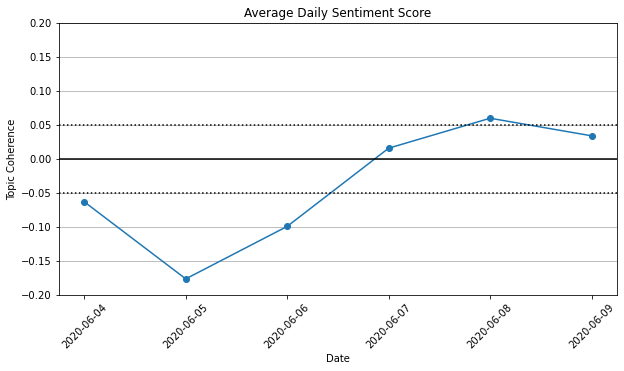

In [24]:
plt.figure(figsize=[10, 5])
plt.plot(sentiment_avg, marker='o')
plt.grid(axis = 'y')
plt.axhline(y = 0.05, color = 'black', linestyle = ':')
plt.axhline(y = 0, color = 'black', linestyle = '-')
plt.axhline(y = -0.05, color = 'black', linestyle = ':')
plt.title("Average Daily Sentiment Score")
plt.xticks(rotation = 45)
plt.xlabel('Date', fontsize = 10)
plt.ylabel('Topic Coherence', fontsize = 10)
plt.ylim([-0.2, 0.2])

# LDA Section

# Finding best K

In [25]:
def topic_coherence(model, n_top_words, pair_score):
    coherences = []
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        coh = 0
        for i in range(len(top_features_ind)):
            for j in range(i):
                coh += pair_score[top_features_ind[i], top_features_ind[j]]
        coherences.append(coh)
    return coherences

## Positive Data-set

In [26]:
#Check: http://qpleple.com/topic-coherence-to-evaluate-topic-models/

In [27]:
# the vectorizer object will be used to transform text to vector form
vectorizer_pos = CountVectorizer(max_df=0.95, min_df=2)

# apply transformation
tf_pos = vectorizer_pos.fit_transform(this_data_pos['clean_text']) #.toarray()

# tf_feature_names tells us what word each column in the matric represents
tf_pos_feature_names = vectorizer_pos.get_feature_names()

# check dimensions
print(tf_pos.shape)

(165, 282)


In [28]:
Dwi = np.array(np.sum(tf_pos > 0, axis=0))[0]

W_bin = tf_pos
W_bin[W_bin > 0] = 1
Dwi_wj = W_bin.T @ W_bin

score_umass_pos = np.log((Dwi_wj.toarray() + 1)/ Dwi)

In [29]:
t0 = time.time()
ks = [2, 3, 4, 5, 6, 7, 8, 9, 10]
pos_topic_cohs = []
for k in ks:
    print(f'running k = {k}')
    this_coh = []
    this_model_pos = LatentDirichletAllocation(n_components=k, random_state=0)
    this_model_pos.fit(tf_pos)
    this_coh.append(np.median(topic_coherence(this_model_pos, 10, score_umass_pos)))
    pos_topic_cohs.append(this_coh)
    
t1 = time.time()

total = t1-t0
print(total, 'seconds')

running k = 2
running k = 3
running k = 4
running k = 5
running k = 6
running k = 7
running k = 8
running k = 9
running k = 10
2.47605299949646 seconds


In [30]:
pos_topic_cohs

[[-89.54710045744918],
 [-74.28494088257118],
 [-58.5895356281062],
 [-75.21174284574651],
 [-41.35168594408828],
 [-41.29518658020844],
 [-48.420942909355304],
 [-40.339196298303406],
 [-48.03799629829336]]

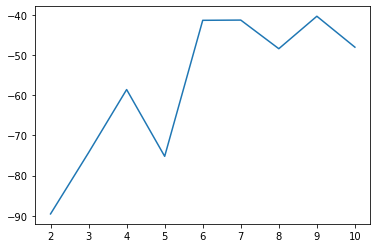

In [31]:
plt.plot(ks, pos_topic_cohs)

## Negative Data-set

In [32]:
# the vectorizer object will be used to transform text to vector form
vectorizer_neg = CountVectorizer(max_df=0.95, min_df=2)

# apply transformation
tf_neg = vectorizer_neg.fit_transform(this_data_neg['clean_text']) #.toarray()

# tf_feature_names tells us what word each column in the matric represents
tf_neg_feature_names = vectorizer_neg.get_feature_names()

# check dimensions
print(tf_neg.shape)

(296, 319)


In [33]:
Dwi_neg = np.array(np.sum(tf_neg > 0, axis=0))[0]

W_bin_neg = tf_neg
W_bin_neg[W_bin_neg > 0] = 1
Dwi_wj_neg = W_bin_neg.T @ W_bin_neg

score_umass_neg = np.log((Dwi_wj_neg.toarray() + 1)/ Dwi_neg)

In [34]:
t0 = time.time()
ks = [2, 3, 4, 5, 6, 7, 8, 9, 10]
neg_topic_cohs = []
for k in ks:
    print(f'running k = {k}')
    this_coh = []
    this_model_neg = LatentDirichletAllocation(n_components=k, random_state=0)
    this_model_neg.fit(tf_neg)
    this_coh.append(np.median(topic_coherence(this_model_neg, 10, score_umass_neg)))
    neg_topic_cohs.append(this_coh)
    
t1 = time.time()

total = t1-t0
print(total, 'seconds')

running k = 2
running k = 3
running k = 4
running k = 5
running k = 6
running k = 7
running k = 8
running k = 9
running k = 10
4.236067056655884 seconds


In [35]:
neg_topic_cohs

[[-66.82650583702525],
 [-80.45546914008638],
 [-79.66323846948531],
 [-65.52759899033241],
 [-74.10741437686876],
 [-71.49779907279745],
 [-67.9183758352611],
 [-66.07519661389166],
 [-69.83634474603207]]

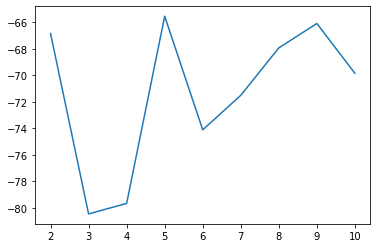

In [36]:
plt.plot(ks, neg_topic_cohs)

## Neutral Data-set

In [37]:
# the vectorizer object will be used to transform text to vector form
vectorizer_neu = CountVectorizer(max_df=0.95, min_df=2)

# apply transformation
tf_neu = vectorizer_neu.fit_transform(this_data_neu['clean_text']) #.toarray()

# tf_feature_names tells us what word each column in the matric represents
tf_neu_feature_names = vectorizer_neu.get_feature_names()

# check dimensions
print(tf_neu.shape)

(166, 197)


In [38]:
Dwi_neu = np.array(np.sum(tf_neu > 0, axis=0))[0]

W_bin_neu = tf_neu
W_bin_neu[W_bin_neu > 0] = 1
Dwi_wj_neu = W_bin_neu.T @ W_bin_neu

score_umass_neu = np.log((Dwi_wj_neu.toarray() + 1)/ Dwi_neu)

In [39]:
t0 = time.time()
ks = [2, 3, 4, 5, 6, 7, 8, 9, 10]
neu_topic_cohs = []
for k in ks:
    print(f'running k = {k}')
    this_coh = []
    this_model_neu = LatentDirichletAllocation(n_components=k, random_state=0)
    this_model_neu.fit(tf_neu)
    this_coh.append(np.median(topic_coherence(this_model_neu, 10, score_umass_neu)))
    neu_topic_cohs.append(this_coh)
    
t1 = time.time()

total = t1-t0
print(total, 'seconds')

running k = 2
running k = 3
running k = 4
running k = 5
running k = 6
running k = 7
running k = 8
running k = 9
running k = 10
1.757242202758789 seconds


In [40]:
neu_topic_cohs

[[-73.54311406149824],
 [-53.4137173112199],
 [-37.09333661408027],
 [-53.37289531669964],
 [-55.62147044247526],
 [-51.29345377501981],
 [-55.40397389447042],
 [-43.01112038929491],
 [-49.35992330263582]]

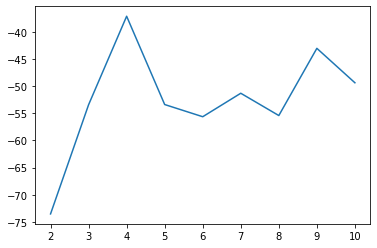

In [41]:
plt.plot(ks, neu_topic_cohs)

# Running on best k

Text(0, 0.5, 'Topic Coherence')

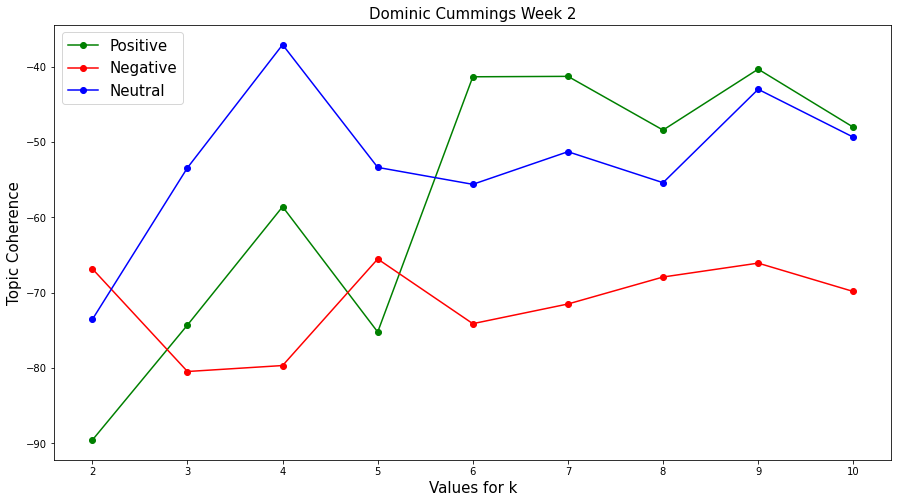

In [42]:
plt.figure(figsize=[15, 8])
plt.title("Dominic Cummings Week 2", fontsize = 15)
plt.plot(ks, pos_topic_cohs, label = 'Positive', marker='o', color = 'g')
plt.plot(ks, neg_topic_cohs, label = 'Negative', marker='o', color = 'r')
plt.plot(ks, neu_topic_cohs, label = 'Neutral', marker='o', color = 'b')
plt.legend(prop={"size":15})
plt.xlabel('Values for k', fontsize = 15)
plt.ylabel('Topic Coherence', fontsize = 15)


In [43]:
def plot_top_words(model, feature_names, n_top_words, title):
    """Function to plot topic models"""
    fig, axes = plt.subplots(2, 3, figsize=(15, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 20})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

## Positive Data-Set

In [44]:
# Choose based on above results
number_of_topics = 6
n_top_words = 10

In [45]:
# model
model_pos = LatentDirichletAllocation(n_components=number_of_topics, random_state=0) # random state for reproducibility

# Fit data to model
t0 = time.time()
model_pos.fit(tf_pos)
t1 = time.time()

total = t1-t0
print(total, 'seconds') #note: 615.2014217376709 seconds

0.29509663581848145 seconds


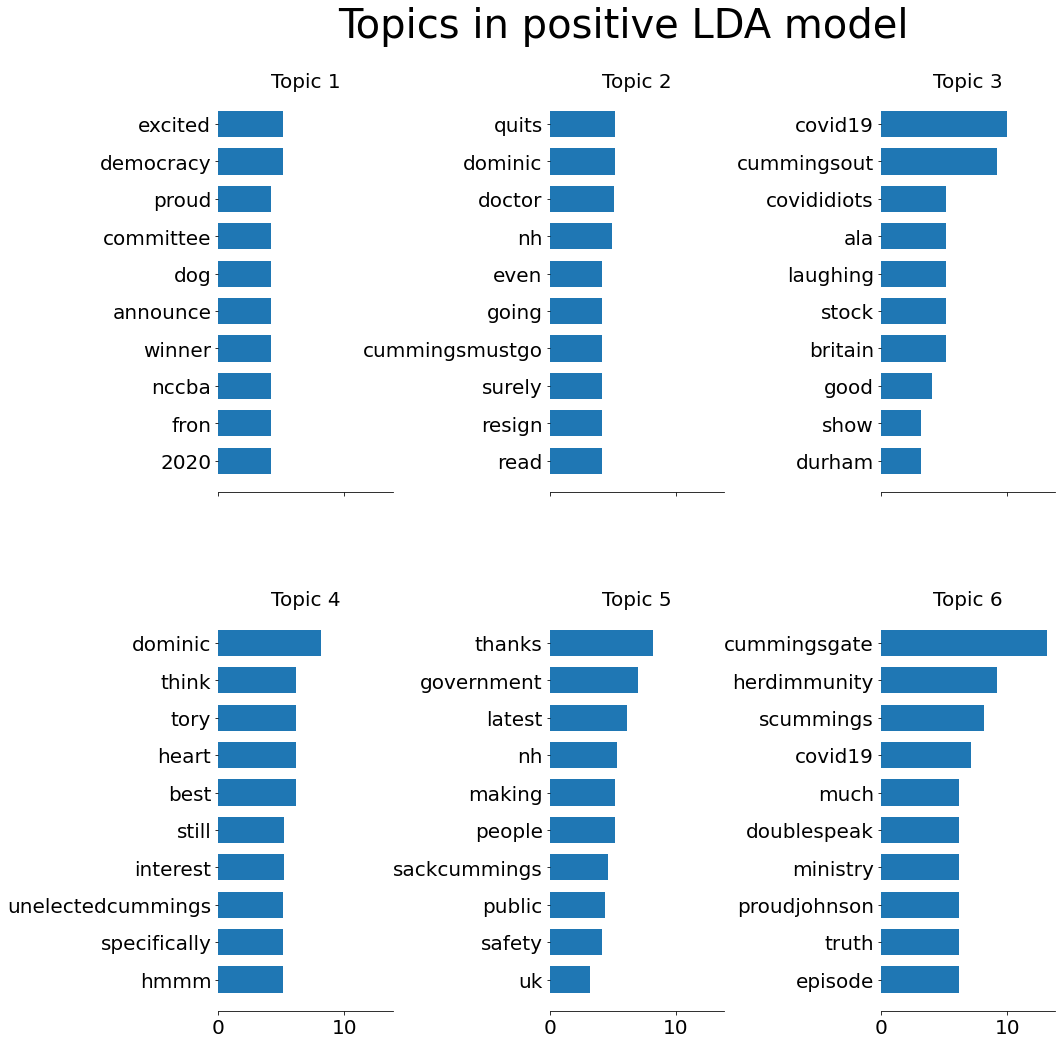

In [46]:
# Names of words 
plot_top_words(model_pos, tf_pos_feature_names, n_top_words, 'Topics in positive LDA model')

## Negative Data-Set

In [47]:
# Choose based on above results
number_of_topics = 5
n_top_words = 10

In [48]:
# model
model_neg = LatentDirichletAllocation(n_components=number_of_topics, random_state=0) # random state for reproducibility

# Fit data to model
t0 = time.time()
model_neg.fit(tf_neg)
t1 = time.time()

total = t1-t0
print(total, 'seconds') #note: 615.2014217376709 seconds

0.3417222499847412 seconds


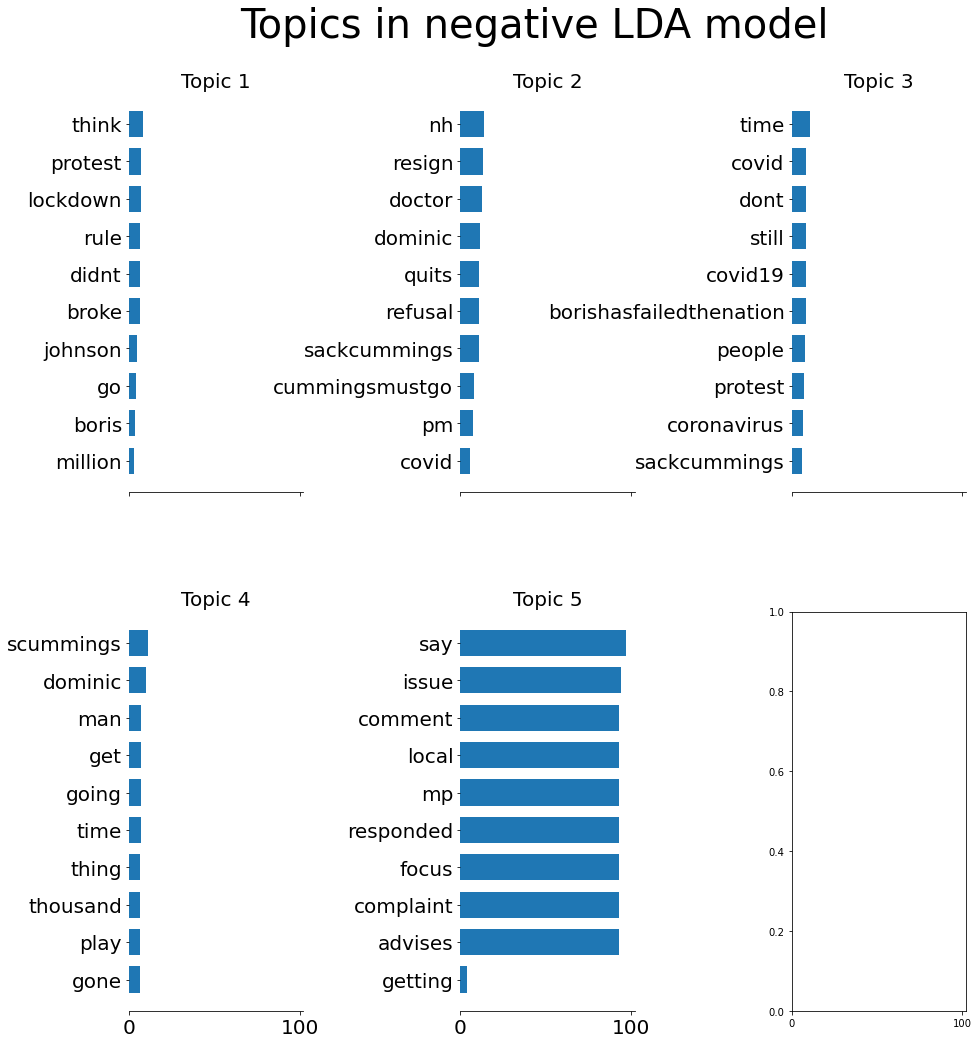

In [49]:
# Names of words 
plot_top_words(model_neg, tf_neg_feature_names, n_top_words, 'Topics in negative LDA model')

## Neutral Data-Set

In [50]:
# Choose based on above results
number_of_topics = 4
n_top_words = 10

In [51]:
# model
model_neu = LatentDirichletAllocation(n_components=number_of_topics, random_state=0) # random state for reproducibility

# Fit data to model
t0 = time.time()
model_neu.fit(tf_neu)
t1 = time.time()

total = t1-t0
print(total, 'seconds') #note: 615.2014217376709 seconds

0.18871307373046875 seconds


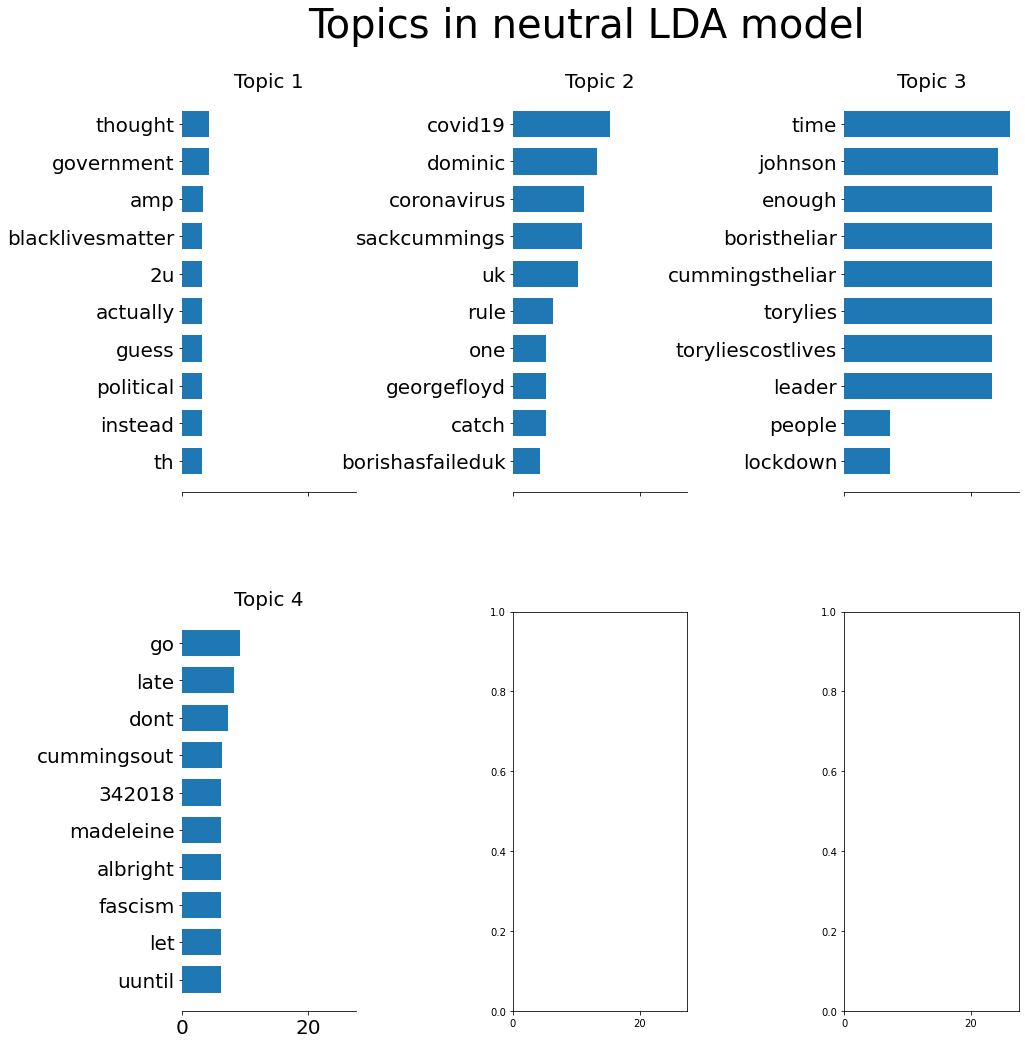

In [52]:
# Names of words 
plot_top_words(model_neu, tf_neu_feature_names, n_top_words, 'Topics in neutral LDA model')